In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

2023-07-25 08:58:23.119265: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-25 08:58:23.174864: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 08:58:23.465177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 08:58:23.467509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 08:58:24.392265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Imported modules.


In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [3]:
# Keras Input tensors of float values.
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude'),
    'median_income':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='median_income'),
    'population':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='population')
}

# Create a Normalization layer to normalize the median_income data.  
median_income = tf.keras.layers.Normalization(
    name='normalization_median_income',
    axis=None)
median_income.adapt(train_df['median_income'])
median_income = median_income(inputs.get('median_income'))

# Create a Normalization layer to normalize the population data. 
population = tf.keras.layers.Normalization(
    name='normalization_population',
    axis=None)
population.adapt(train_df['population'])
population = population(inputs.get('population'))

# Create a list of numbers representing the bucket boundaries for latitude.
# Because we're using a Normalization layer, values for latitude and longitude
# will be in the range of approximately -3 to 3 (representing the Z score).
# We'll create 20 buckets, which requires 21 bucket boundaries (hence, 20+1).
latitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Normalization layer to normalize the latitude data.
latitude = tf.keras.layers.Normalization(
    name='normalization_latitude',
    axis=None)
latitude.adapt(train_df['latitude'])
latitude = latitude(inputs.get('latitude'))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(latitude)

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Normalization layer to normalize the longitude data.
longitude = tf.keras.layers.Normalization(
    name='normalization_longitude',
    axis=None)
longitude.adapt(train_df['longitude'])
longitude = longitude(inputs.get('longitude'))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(longitude)

# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    # num_bins can be adjusted: Higher values improve accuracy, lower values
    # improve performance.
    num_bins=len(latitude_boundaries) * len(longitude_boundaries), 
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

# Concatenate our inputs into a single tensor.
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population])

print("Preprocessing layers defined.")

Preprocessing layers defined.


In [4]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")
  
  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97 

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [5]:
#@title Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(
    np.array(train_df['median_house_value']))

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(
    np.array(test_df['median_house_value']))

def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_median_house_value_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [6]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1, input_shape=(1,),
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

Epoch 1/15


/home/franksitawa/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 0s 12ms/step - loss: 0.8100 - mean_squared_error: 0.8100 - val_loss: 0.6464 - val_mean_squared_error: 0.6464
Epoch 2/15
14/14 [==============================] - 0s 3ms/step - loss: 0.5872 - mean_squared_error: 0.5872 - val_loss: 0.4848 - val_mean_squared_error: 0.4848
Epoch 3/15
14/14 [==============================] - 0s 3ms/step - loss: 0.4561 - mean_squared_error: 0.4561 - val_loss: 0.3984 - val_mean_squared_error: 0.3984
Epoch 4/15
14/14 [==============================] - 0s 3ms/step - loss: 0.3911 - mean_squared_error: 0.3911 - val_loss: 0.3603 - val_mean_squared_error: 0.3603
Epoch 5/15
14/14 [==============================] - 0s 3ms/step - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3447 - val_mean_squared_error: 0.3447
Epoch 6/15
14/14 [==============================] - 0s 3ms/step - loss: 0.3527 - mean_squared_error: 0.3527 - val_loss: 0.3379 - val_mean_squared_error: 0.3379
Epoch 7/15
14/14 [==============================] 

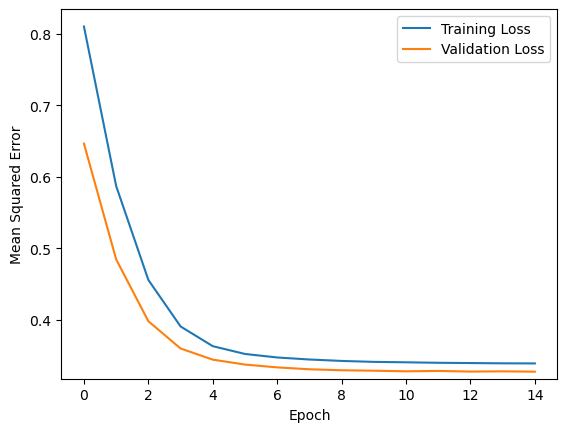


 Evaluate the linear regression model against the test set:
3/3 [==============================] - 0s 3ms/step - loss: 0.3613 - mean_squared_error: 0.3613


{'loss': 0.3613415062427521, 'mean_squared_error': 0.3613415062427521}

In [7]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set. 
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [8]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20, input_shape=(1,),
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12, input_shape=(1,),
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1, input_shape=(1,),
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

Epoch 1/20


/home/franksitawa/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 0s 11ms/step - loss: 0.6880 - mean_squared_error: 0.6880 - val_loss: 0.3996 - val_mean_squared_error: 0.3996
Epoch 2/20
14/14 [==============================] - 0s 4ms/step - loss: 0.3804 - mean_squared_error: 0.3804 - val_loss: 0.3434 - val_mean_squared_error: 0.3434
Epoch 3/20
14/14 [==============================] - 0s 4ms/step - loss: 0.3429 - mean_squared_error: 0.3429 - val_loss: 0.3241 - val_mean_squared_error: 0.3241
Epoch 4/20
14/14 [==============================] - 0s 4ms/step - loss: 0.3292 - mean_squared_error: 0.3292 - val_loss: 0.3140 - val_mean_squared_error: 0.3140
Epoch 5/20
14/14 [==============================] - 0s 4ms/step - loss: 0.3256 - mean_squared_error: 0.3256 - val_loss: 0.3121 - val_mean_squared_error: 0.3121
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3237 - mean_squared_error: 0.3237 - val_loss: 0.3117 - val_mean_squared_error: 0.3117
Epoch 7/20
14/14 [==============================] 

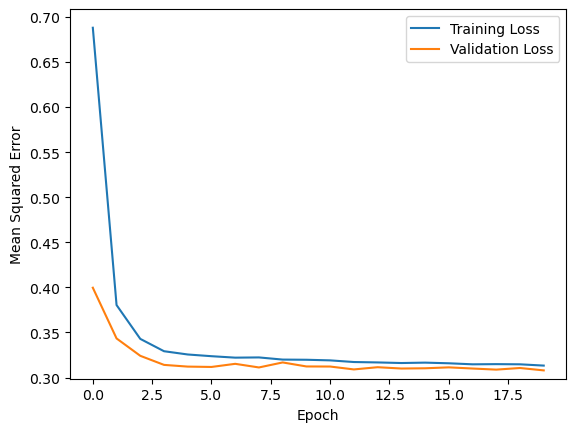


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 2ms/step - loss: 0.3420 - mean_squared_error: 0.3420


{'loss': 0.3419690430164337, 'mean_squared_error': 0.3419690430164337}

In [9]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set. 
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name))) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [10]:
# Assuming that the linear model converged and
# the deep neural net model also converged, please 
# compare the test set loss for each.
# In our experiments, the loss of the deep neural 
# network model was consistently lower than 
# that of the linear regression model, which 
# suggests that the deep neural network model 
# will make better predictions than the 
# linear regression model.

In [ ]:
# Many answers are possible.  We noticed the 
# following trends:
#   * Two layers outperformed one layer, but 
#     three layers did not perform significantly 
#     better than two layers.
#     In other words, two layers seemed best. 
#   * Setting the topography as follows produced 
#     reasonably good results with relatively few 
#     nodes:
#       * 10 nodes in the first layer.
#       *  6 nodes in the second layer.
#     As the number of nodes in each layer dropped
#     below the preceding, test loss increased.  
#     However, depending on your application, hardware
#     constraints, and the relative pain inflicted 
#     by a less accurate model, a smaller network 
#     (for example, 6 nodes in the first layer and 
#     4 nodes in the second layer) might be 
#     acceptable.